In [113]:
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt

Data_2D = scio.loadmat('data_sets/ex8data1.mat')
print(Data_2D.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])


In [114]:
X = Data_2D['X']
Xval = Data_2D['Xval']
yval = Data_2D['yval']
print(X.shape)
print(Xval.shape)
print(yval.shape)

(307, 2)
(307, 2)
(307, 1)


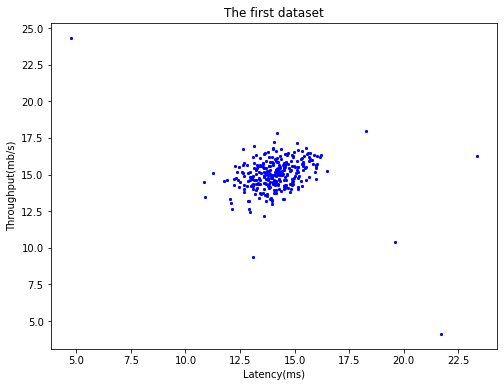

In [115]:
def plot_data(x):
    plt.figure(figsize = (8, 6))
    plt.xlabel('Latency(ms)')
    plt.ylabel('Throughput(mb/s)')
    plt.scatter(x[:, 0], x[:, 1], marker = 'x', c = 'b', s = 5)
    plt.title('The first dataset')

plot_data(X)

In [116]:
def get_gaussian_params(x, use_multivariate):
    mu = x.mean(axis = 0)
    if use_multivariate:
        sigma2 = ((x - mu).T @ (x - mu)) / len(x)
    else:
        sigma2 = x.var(axis = 0, ddof = 0) # 自由度为m-0
    return mu, sigma2

def gaussian(x, mu, sigma2):
    m, n = x.shape
    if np.ndim(sigma2) == 1:
        sigma2 = np.diag(sigma2) # make sigma2 become a diagonal covariance matrix from a vector
    
    norm = 1 / (np.power(2 * np.pi, n/2) * np.sqrt(np.linalg.det(sigma2)))
    exp = np.zeros(m)
    for row in range(m):
        x_row = x[row]
        exp[row] = np.exp( -0.5 * (x_row - mu).T @ np.linalg.inv(sigma2) @ (x_row - mu))
    return norm * exp    
        
def plot_contours(mu, sigma2):
    delta = .3
    
    x = np.arange(0, 30, delta)
    y = np.arange(0, 30, delta)
    
    xx, yy = np.meshgrid(x, y)
    points = np.c_[xx.ravel(), yy.ravel()] # concatenate in the form of cols. The first col denotes the X axis, and second denotes the Y axis
    z = gaussian(points, mu, sigma2)
    z = z.reshape(xx.shape)
    
    cont_levels = [10**h for h in range(-20, 0, 3)] # 这个levels是作业里面给的参考,或者通过求解的概率推出来。
    CS = plt.contour(xx, yy, z, cont_levels)
    plt.clabel(CS, inline = 1, fontsize = 10, colors = 'r')
    
    plt.title('Gaussian Contours', fontsize = 16)

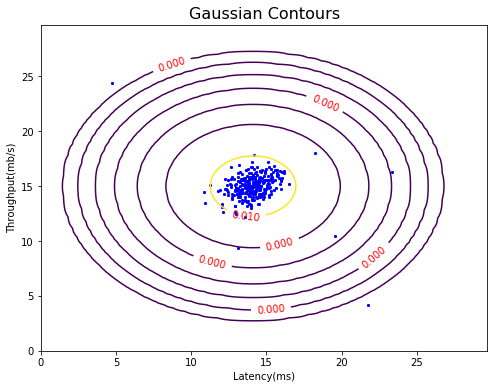

In [117]:
# First contours without using multivariate gaussian.
plot_data(X)
plot_contours(*get_gaussian_params(X, False))

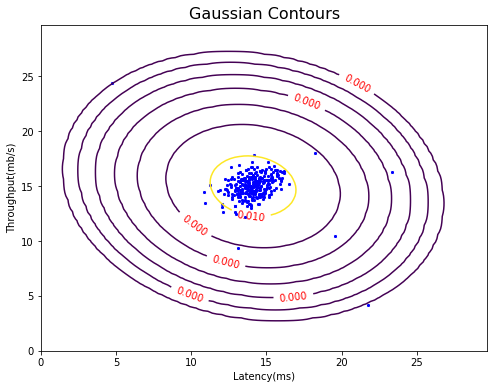

In [118]:
# Then contours with multivariate gaussian:
plot_data(X)
plot_contours(*get_gaussian_params(X, True))

In [119]:
'''
Selecting the threshold(epsilon) based on the cross validation
'''
def select_threshold(p_val, y_val):
    '''
    p_val: the vector of a cross validation set of probabilities
    y_val: the corresponding labels 
    '''
    best_F1 = 0
    best_epsilon = 0
    y_pred = np.zeros(y_val.shape)
    for epsilon in np.linspace(min(p_val), max(p_val), 1000):
        #  If an examplex has a low probabilityp(x) < ε,then it is considered to be an anomaly. 
        y_pred[p_val < epsilon] = 1
        y_pred[p_val > epsilon] = 0
        tp = np.sum(y_val[y_pred == 1]) # y_val == 1 and p_val < epsilon
        prec = tp / np.sum(y_pred) if np.sum(y_pred) else 0
        rec = tp / np.sum(y_val) if np.sum(y_val) else 0
        F1 = (2 * prec * rec) / (prec + rec) if (prec + rec) else 0
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
    return best_epsilon, best_F1

In [120]:
mu, sigma2 = get_gaussian_params(X, False)
epsilon, F1 = select_threshold(gaussian(Xval, mu, sigma2), yval)
print(epsilon)
print(F1)

8.999852631901397e-05
0.8750000000000001


Text(0.5, 1.0, 'The classified anomalies.')

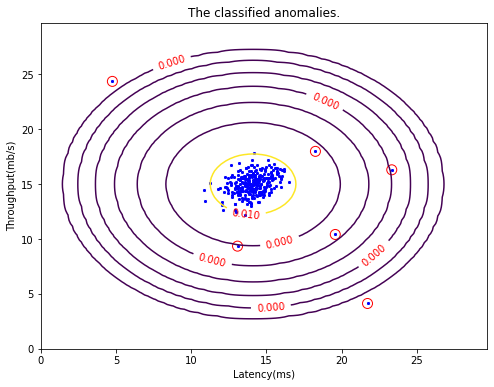

In [121]:
'''
Circle the anomalies in the plot
'''
X_prob = gaussian(X, mu, sigma2)
outliers = np.array([X[i] for i in range(len(pval)) if X_prob[i] < epsilon])

plot_data(X)
plot_contours(mu, sigma2)
plt.scatter(outliers[:, 0], outliers[:, 1], s = 100, facecolors = 'none', edgecolors = 'r')
plt.title('The classified anomalies.')

In [122]:
'''
High dimensional dataset
'''
Data = scio.loadmat('data_sets/ex8data2.mat')
print(Data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])


In [123]:
X2 = Data['X']
Xval2, yval2 = Data['Xval'], Data['yval']
print(X2.shape)
print(Xval2.shape)

(1000, 11)
(100, 11)


In [124]:
mu, sigma2 = get_gaussian_params(X2, False)
X2_prob = gaussian(X2, mu, sigma2)

yval2_prob = gaussian(Xval2, mu, sigma2)

epsilon, F1 = select_threshold(yval2_prob, yval2)
outliers = [X2[i] for i in range(len(X2_prob)) if X2_prob[i] < epsilon]
print(epsilon)
print(len(outliers))
print(F1)

1.3786074982000245e-18
117
0.6153846153846154
